In [1]:
%matplotlib inline

import numpy as np
import csv
import matplotlib.pylab as plt
from IPython.core.pylabtools import figsize
from collections import OrderedDict
from scipy.stats import linregress
from scipy.optimize import differential_evolution

figsize(10, 8)

In [2]:
class HoltWinters(object):
    """Holt-Winters algorithm for forecasting time series"""
    
    def __init__(self, ts_dir, window, init_fit_first_n=None):
        """
        Initialize parameters used in Holt-Winters.
        
            ts_dr (str): String name of csv file containing time series data.
            window (int): Length of seasonality. Used in determining seed values for 
                Holt-Winters algorithm.
            trend_fit_first_n (int): The number of data points from the de-seasonalized 
                data for which to fit a line to in order to get the initial trend and 
                level values.
        """
        
        self.ts_dir = ts_dir
        self.read_ts_csv()
        self.window = window
        self.init_fit_first_n = init_fit_first_n
    
    def read_ts_csv(self):
        """
        Read in time-series from a csv. Result is stored in an ordered dict.
        """
        
        ts = OrderedDict()
        with open(self.ts_dir, "rb") as csv_file:
            lines = csv.reader(csv_file)
            # skip header
            lines.next()
            for line in lines:
                ts[int(line[0])] = float(line[1])
        
        self.ts = ts
        self.n = len(ts)
    
    @staticmethod
    def moving_average(ts, window):
        """
        Fits a moving average to a time series.
        
            ts (Ordered Dict): An ordered dictionary of time series data where the keys 
                are integers representing date and the values are corresponding time-series
                metrics.
            window (int): Length of moving average. If *window* is even, a 2-by-*window*
                moving average is calculated. Entries where a moving average cannot be 
                calculated due to window size are set to 0.
        """
        
        ma = np.zeros(len(ts))
        weights = np.repeat(1.0, window)/window

        if window%2 == 0:
            # window is even
            ma1 = np.convolve(ts[:-1], weights, 'valid')
            ma2 = np.convolve(ts[1:], weights, 'valid')
            ma[window/2:-window/2] = 0.5*(ma1 + ma2)
        else:
            # window is odd
            ma[(window - 1)/2:-(window - 1)/2] = np.convolve(ts, weights, 'valid')

        return (ma)
    
    def get_initial_vals(self, init_plot=False):
        """
        Gets initial level, trend, and seasonality adjustments for Holt-Winters. 
        A window unit moving average is fit to the data to achieve this.
        
           init_plot (binary): Whether or not to plot time series related to initialization
                of Holt-Winters. Namely, the de-season and moving average time series.
        """
        
        ts = self.ts
        init_fit_first_n = self.init_fit_first_n
        window = self.window
        season_adj_factor = {}
        ts_vals = np.asarray(ts.values())
        ts_keys = np.asarray(ts.keys())

        ma = self.moving_average(ts_vals, window)

        if window%2 == 0:
            ix_bound = window/2    
        else:
            ix_bound = (window - 1)/2

        # Calculate seasonal adjustment factors
        season_adj_factor_vals = ts_vals[ix_bound:-ix_bound]/ma[ix_bound:-ix_bound]
        for date_ix, season_adj_factor_val in zip(ts_keys[ix_bound:-ix_bound], season_adj_factor_vals):
            try:
                season_adj_factor[date_ix%window].append(season_adj_factor_val)
            except KeyError:
                season_adj_factor[date_ix%window] = [season_adj_factor_val]

        for key, val in season_adj_factor.iteritems():
            season_adj_factor[key] = np.mean(val)

        # Create de-seasonalized data to calculate initial trend and level
        deseason_ts = [val/season_adj_factor[key%window] for key, val in ts.iteritems()]

        trend_0, level_0, _, _, _ = linregress(ts_keys[:init_fit_first_n], 
                                               deseason_ts[:init_fit_first_n])

        if init_plot:
            plt.plot(ts_keys, deseason_ts, '--k', label="de-seasonalized")
            plt.plot(ts_keys, ts_vals, '-k', label="raw")
            plt.plot(ts_keys, ma, '*k', label="moving avg")
            plt.legend(loc="best")
            plt.xlabel("Date Index")
            plt.ylabel("Metric")
            plt.show()

        return (level_0, trend_0, season_adj_factor)
    
    @staticmethod
    def _update_forecast_onestep(level, trend, season_adj_factor):
        return ((level + trend)*season_adj_factor)
    
    @staticmethod
    def _update_level(level, trend, alpha, forecast_error, season_adj_factor):
        return (level + trend + alpha*forecast_error/season_adj_factor)
    
    @staticmethod
    def _update_trend(trend, alpha, gamma, forecast_error, season_adj_factor):
        return (trend + gamma*alpha*forecast_error/season_adj_factor)
        
    @staticmethod
    def _update_season_adj_factor(level, trend, alpha, delta, forecast_error, season_adj_factor):
        return (season_adj_factor + delta*(1.0 - alpha)*forecast_error/(level + trend))
    
    def holt_winters(self, alpha, gamma, delta, save_params=False):
        """
        Applies the Holt-Winters algorithm to generate a time series forecast. 
        """
        
        n = self.n
        window = self.window
        forecast_one_step = np.zeros(n)
        forecast_error = np.zeros(n)

        # Initialize Holt-Winters iteration variables
        level_0, trend_0, season_adj_factors = self.get_initial_vals()
        level, trend = level_0, trend_0

        for i, (date_ix, metric) in enumerate(self.ts.iteritems()):
            season_ix = date_ix%window
            season_adj_factor = season_adj_factors[season_ix]
            forecast_one_step[i] = self._update_forecast_onestep(level_0, trend_0, season_adj_factor)
            forecast_error[i] = metric - forecast_one_step[i]
            level = self._update_level(level_0, trend_0, alpha, forecast_error[i], season_adj_factor)
            trend = self._update_trend(trend_0, alpha, gamma, forecast_error[i], season_adj_factor)
            season_adj_factors[season_ix] = self._update_season_adj_factor(level_0, trend_0, 
                                                                           alpha, delta, 
                                                                           forecast_error[i], 
                                                                           season_adj_factor)

            level_0 = level
            trend_0 = trend

        standard_error = np.sqrt(np.sum(forecast_error**2)/(n - 3.0))
        
        if save_params:
            self._level_opt = level
            self._trend_opt = trend
            self._alpha_opt = alpha
            self._gamma_opt = gamma
            self._delta_opt = delta
            self._season_adj_factors_opt = season_adj_factors
            self._standard_error = standard_error

        return (forecast_one_step, forecast_error, standard_error)
    
    def fit_holt_winters(self):
        """
        Uses an evolutionary algorithm to identify the alpha, gamma, delta
        parameters that minimize the standard error in Holt-Winters fit.
        """
        
        opt_dummy = lambda x: self.holt_winters(*x)[2]
        opt_res = differential_evolution(opt_dummy, bounds=[[0., 1.]]*3)
 
        assert opt_res["success"] == True, "Optimization failed"
        self.holt_winters(*opt_res["x"], save_params=True)
    
    def holt_winters_best_fit(self):
        """
        Determines Holt-Winters forecast corresponding to alpha, gamma and
        delta values that minimize the standard error. 
        """
        
        forecast_one_step, forecast_error, _ = self.holt_winters(self._alpha_opt, 
                                                                 self._gamma_opt,
                                                                 self._delta_opt)
        return (forecast_one_step, forecast_error)
        
    def predict(self, forecast_n_steps, n_sims):
        """
        Forecast metric value for future times.
        
            forecast_n_steps (int): Number of time-steps for which a forecast is desired.
            n_sims (int): Number of simulations to perform of the forecast such that
                95% confidence bounds can be applied to the forecast.
        """
        
        metric_forecast = np.zeros([forecast_n_steps, n_sims])

        # perform n_sims number of simulations for future demand
        for n_sim in xrange(n_sims):
            # reset relevant variables    
            alpha = self._alpha_opt
            gamma = self._gamma_opt
            delta = self._delta_opt
            level = self._level_opt
            trend = self._trend_opt
            season_adj_factors = self._season_adj_factors_opt
            standard_error = self._standard_error
            window = self.window
            n = self.n
            level_0, trend_0 = level, trend
            
            forecast_error = np.zeros(forecast_n_steps)
            forecast_one_step = np.zeros(forecast_n_steps)
            for i, date_ix in enumerate(xrange(n + 1, n + forecast_n_steps + 1)):
                season_ix = date_ix%window
                season_adj_factor = season_adj_factors[season_ix]
                forecast_error[i] = np.random.normal(scale=standard_error)
                forecast_one_step[i] = self._update_forecast_onestep(level_0, trend_0, season_adj_factor)
                level = self._update_level(level_0, trend_0, alpha, forecast_error[i], season_adj_factor)
                trend = self._update_trend(trend_0, alpha, gamma, forecast_error[i], season_adj_factor)
                season_adj_factors[season_ix] = self._update_season_adj_factor(level_0, trend_0, 
                                                                               alpha, gamma, 
                                                                               forecast_error[i], 
                                                                               season_adj_factor)
                level_0 = level
                trend_0 = trend

            metric_forecast[:, n_sim] = forecast_one_step + forecast_error

        metric_mean = np.mean(metric_forecast, axis=1)
        metric_lb, metric_ub = np.percentile(metric_forecast, q=[2.5, 97.5], axis=1)

        return (metric_mean, metric_lb, metric_ub)
    
    def plot_correlogram(self, forecast_error):
        """
        Plots the correlogram for a given forecast.
        
            forecast_error (numpy array): Forecast error for Holt-Winters
        """
        
        # Autocorrelation
        error_mean_delta = forecast_error - np.mean(forecast_error)
        total_error = np.dot(error_mean_delta, error_mean_delta)
        lags = np.zeros(self.window)
        
        for i in xrange(1, self.window + 1):
            lags[i-1] = np.dot(error_mean_delta[i:], error_mean_delta[:-i])/total_error

        plt.vlines(range(1, self.window + 1), 0, lags)   
        plt.hlines(0, 0, self.window + 2)

        # Significance level for autocorrelation
        ac_bound = 2./np.sqrt(self.n)
        plt.hlines(ac_bound, 0, self.window + 2, color="k", linestyles="dashed")
        plt.hlines(-ac_bound, 0, self.window + 2, color="k", linestyles="dashed")
        plt.xlabel("Lag")
        plt.ylabel("Autocorrelation")
        plt.title("Correlogram for Forecast Error")
        plt.show();

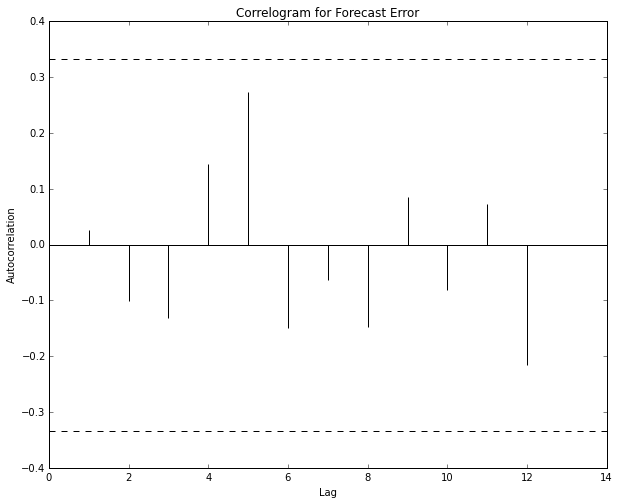

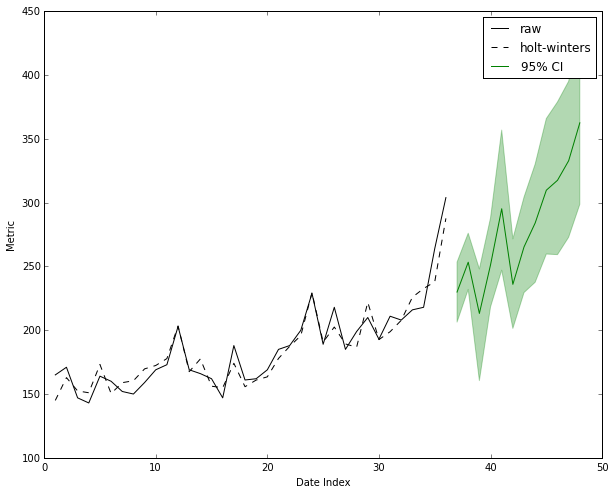

In [4]:
hw = HoltWinters("demand.csv", window=12)
hw.fit_holt_winters()

forecast_one_step, forecast_error = hw.holt_winters_best_fit()
future_mean, future_lb, future_ub = hw.predict(forecast_n_steps=12, n_sims=500)

# Plot correlogram
hw.plot_correlogram(forecast_error)

# Plot forecast
plt.plot(hw.ts.keys(), hw.ts.values(), "-k", label="raw")
plt.plot(hw.ts.keys(), forecast_one_step, "--k", label="holt-winters")

x_future_min = max(hw.ts.keys()) + 1
x_future = range(x_future_min, x_future_min + len(future_mean))
plt.plot(x_future, future_mean, color='green', label="95% CI")
plt.fill_between(x_future, future_ub, future_lb, color="green", alpha=0.3)
plt.legend(loc="best")
plt.xlabel("Date Index")
plt.ylabel("Metric");